# Food Description Transformer Model

This notebook trains a Decoder-Only Transformer model to learn patterns from food descriptions and associated data stored in a CSV file. It performs the following steps:

1.  **Imports & Setup:** Imports necessary libraries and checks for the availability of `torch` and `tokenizers`.
2.  **Data Creation:** Creates a placeholder `food_predictions.csv` if it doesn't exist, allowing the notebook to run initially.
3.  **Tokenizer:** Defines and trains a Byte-Pair Encoding (BPE) tokenizer on the input text data.
4.  **Dataset:** Defines a custom dataset class to load, preprocess, and tokenize the data from the CSV.
5.  **Model Definition:** Defines the `DecoderOnlyTransformer` architecture and a wrapper class (`DecoderOnlyModelWrapper`) that includes the model, optimizer, and loss function.
6.  **Training Loop:** Implements the training process, including validation, loss calculation, early stopping, and plotting of training/validation loss.
7.  **Testing:** Includes several test functions to verify basic model functionality (forward pass, handling different inputs).
8.  **Evaluation:** Defines functions to compute and visualize a confusion matrix and calculate precision, recall, and F1-score.
9.  **Main Execution:** Orchestrates the entire workflow: loading data, training the tokenizer, initializing the model, running tests, training the model, evaluating performance, and saving the trained model and reports.
10. **Logging:** Redirects output to both the console and a `log.txt` file.

## Imports and Setup

Import necessary libraries. We check if `torch` and `tokenizers` are available and set flags accordingly.

In [1]:
import sys
import os
import math
import re
import csv
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import json # For writing the notebook itself

import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

In [2]:
%pip install pandas numpy matplotlib scikit-learn torch tokenizers seaborn optuna oauth2client gdown pytorch-lightning lightning-bolts

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Data Import

In [3]:
import os
import csv
import io

csv_file_path = "food_predictions.csv"

# Check if running in Colab
is_colab = 'google.colab' in str(get_ipython())

if is_colab:
    # Colab-specific code
    try:
        from google.colab import drive
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
        
        # Mount Google Drive
        drive.mount('/content/drive')
        
        # Authenticate with Google Drive
        auth.authenticate_user()
        gauth = GoogleCredentials.get_application_default()
        
        # File ID from Google Drive URL
        file_id = '1RFhhiSFwP0s6Y7y4yWCkegXlVaEYqH0B'  # Replace with the actual file ID
        drive_file_path = f'/content/drive/MyDrive/food_predictions.csv'  # Update the path if necessary
        
        # Check if CSV exists locally, or download from Google Drive
        if not os.path.exists(csv_file_path):
            try:
                # Download file from Google Drive
                !gdown --id $file_id -O $csv_file_path
                print(f"[INFO] Downloaded '{csv_file_path}' from Google Drive.")
            except Exception as e:
                print(f"[ERROR] Failed to download from Google Drive: {e}")
                raise FileNotFoundError(f"Could not download or find '{csv_file_path}'. Please ensure the file ID and path are correct.")
        else:
            print(f"[INFO] Found existing '{csv_file_path}' in Colab. Using this file.")
    except ImportError:
        print("[WARN] Google Colab modules not available but detected in Colab environment.")
else:
    # Local environment (VS Code, etc.)
    if os.path.exists(csv_file_path):
        print(f"[INFO] Found existing '{csv_file_path}' locally. Using this file.")
    else:
        # Create a simple placeholder CSV if it doesn't exist
        try:
            with open(csv_file_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['food_description', 'contains_allergen', 'sweetener', 'fats_oils'])
                writer.writerow(['Sample food item 1', 'True', 'sugar', 'olive oil'])
                writer.writerow(['Sample food item 2', 'False', 'none', 'none'])
            print(f"[INFO] Created placeholder '{csv_file_path}' for local development.")
            print("[NOTE] Replace this with your actual data file for meaningful results.")
        except Exception as e:
            print(f"[ERROR] Failed to create placeholder CSV: {e}")
            raise

[INFO] Found existing 'food_predictions.csv' locally. Using this file.


# Data Exploration

Let's explore the data to understand the distribution and structure of the dataset.

In [4]:
df = pd.read_csv(csv_file_path)

print("DF Head")
df.head()

DF Head


,food_description,main_ingredient,sweetener,fat_or_oil,seasoning,allergens,contains_allergen
0,"Creamy scrambled eggs, crispy bacon, and toast...",Eggs,NaN,NaN,Bacon,"Dairy, Eggs",true
1,omg best pizza i ever had: gooey melted mozzar...,Mozzarella,NaN,NaN,"Tomato sauce, Crispy crust","Dairy, Wheat",true
2,"Warm, flaky croissants filled with buttery, ga...",Spinach,NaN,Butter,Garlic,"Almond, Dairy",True
3,"Decadent chocolate cake, moist and rich, serve...",Chocolate,Sugar,NaN,NaN,Dairy,true
4,Fresh catch of the day: pan-seared salmon with...,salmon,NaN,NaN,"lemon, herb",Fish,true


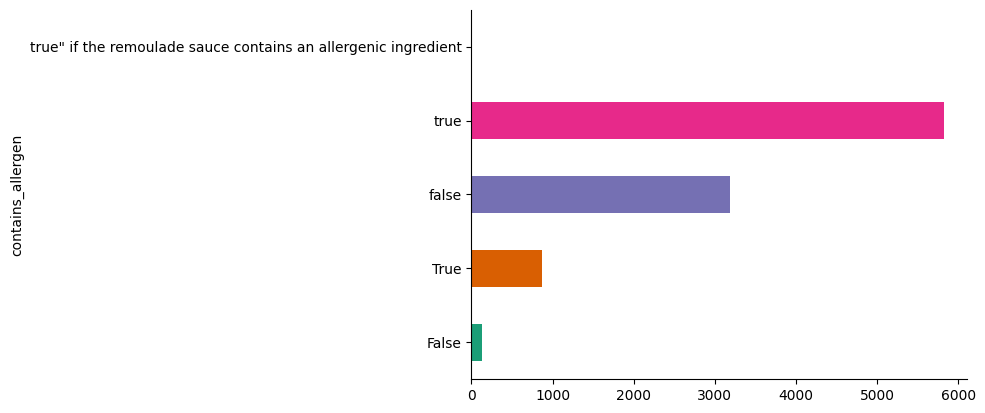

In [5]:
# @title contains_allergen

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('contains_allergen').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Let's look at the factor data types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   food_description   10020 non-null  object
 1   main_ingredient    9865 non-null   object
 2   sweetener          3666 non-null   object
 3   fat_or_oil         3501 non-null   object
 4   seasoning          7891 non-null   object
 5   allergens          7548 non-null   object
 6   contains_allergen  10020 non-null  object
dtypes: object(7)
memory usage: 548.1+ KB


Let's look at the number of unique values for each factor. Most noteworthy, the food_descriptions are almost all unique, which is expected. And all of the samples have a value in the contains_allergen column.

In [7]:
df.describe()

,food_description,main_ingredient,sweetener,fat_or_oil,seasoning,allergens,contains_allergen
count,10020,9865,3666,3501,7891,7548,10020
unique,9988,988,578,469,2778,1587,5
top,Fried chicken tenders with honey mustard dippi...,chicken,Sugar,Butter,none,Dairy,true
freq,2,895,497,721,285,1547,5821


There appears to be a majority of items that either don't have a predicted sweetner or fat/oil.

In [8]:
df.isnull().sum()

food_description        0
main_ingredient       155
sweetener            6354
fat_or_oil           6519
seasoning            2129
allergens            2472
contains_allergen       0
dtype: int64

## BPE Tokenizer

This class handles tokenization. It uses the `tokenizers` library to train a Byte-Pair Encoding (BPE) model on the provided text data. BPE is effective at handling unknown words by breaking them down into subword units.

If the `tokenizers` library is unavailable, it falls back to a simple character-level tokenizer.

In [9]:
class BPETokenizer:
    """ Wrapper for BPE Tokenizer"""
    def __init__(self, texts):
        """ Initializes and trains the tokenizer.

        Args:
            texts (iterable): An iterable of strings to train the tokenizer on.
        """
        # Use Hugging Face tokenizers library
        self.tokenizer = Tokenizer(BPE(unk_token="<unk>"))
        self.tokenizer.pre_tokenizer = Whitespace()
        # Define special tokens, ensuring <pad> is handled correctly (often ID 0 by convention)
        trainer = BpeTrainer(special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"])
        # Train the tokenizer
        self.tokenizer.train_from_iterator(texts, trainer=trainer)
        # Ensure pad token ID is 0 if possible (it usually is by default with BpeTrainer)
        pad_token_id = self.tokenizer.token_to_id("<pad>")
        if pad_token_id is None:
              print("[WARN] <pad> token not found after training!")
              # Handle this case if necessary, maybe re-train or add manually
        elif pad_token_id != 0:
              print(f"[WARN] <pad> token ID is {pad_token_id}, not 0. CrossEntropyLoss might need ignore_index adjustment if not using 0.")
        print(f"[INFO] Trained BPE tokenizer. Vocab size: {self.tokenizer.get_vocab_size()}")

    def encode(self, text):
        # Encode with BOS and EOS tokens implicitly handled via format string during encoding
        bos_token = self.tokenizer.token_to_id("<bos>")
        eos_token = self.tokenizer.token_to_id("<eos>")

        encoded = self.tokenizer.encode(text) # Encode the main text

        # Manually add BOS and EOS if not added automatically or if specific placement is needed
        output_ids = []
        if bos_token is not None:
            output_ids.append(bos_token)
        output_ids.extend(encoded.ids)
        if eos_token is not None:
              output_ids.append(eos_token)
        return output_ids

    def decode(self, ids):
        """ Decodes a list of token IDs back into a string. """
        # Use the tokenizer's decode method
        return self.tokenizer.decode(ids, skip_special_tokens=False) # Keep special tokens for clarity if needed

    @property
    def vocab_size(self):
        """ Returns the size of the vocabulary. """
        return self.tokenizer.get_vocab_size()

    def token_to_id(self, token):
        """ Converts a token string to its ID."""
        return self.tokenizer.token_to_id(token)

    def id_to_token(self, id):
        """ Converts a token ID to its string representation."""
        return self.tokenizer.id_to_token(id)

    @property
    def pad_id(self):
        """ Returns the ID of the padding token."""
        return self.token_to_id("<pad>")

## Dataset and Collation

### `VectorizedFoodDataset` Class
Reads the `food_prediction.csv` file. It takes the `food_description` column and vectorizes it. The `contains_allergen` is then encoded to use 1 and 0 instead of true and false.

### `FoodDataset` Class
Reads the `food_predictions.csv` file. It assumes the first column is `food_description` and concatenates all other columns into a structured `OUTPUT:` section. It then tokenizes this combined text.

### `collate_fn` Function
Takes a batch of sequences (lists of token IDs) from the dataset and pads them to the length of the longest sequence in the batch. It creates an attention mask to indicate which tokens are real and which are padding. This is necessary for batch processing in PyTorch.

In [10]:
class VectorizedFoodDataset:
    def __init__(self, csv_path, vectorizer):
        df = pd.read_csv(csv_path)



        descriptions = df["food_description"].tolist()
        bool_array = np.char.lower(df["contains_allergen"].tolist()) == "true"

        self.targets = np.array(bool_array, dtype=int)
        self.features = vectorizer.fit_transform(descriptions)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

    def __clean_text(text):
        """Cleans the input text by removing irrelevant characters and converting to lowercase."""
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        text = text.lower()  # Convert to lowercase
        return text


class FoodDataset:
    """ Loads and preprocesses data from the food CSV file."""
    def __init__(self, csv_path, max_len=128):
        """ Initializes the dataset.

        Args:
            csv_path (str): Path to the input CSV file.
            max_len (int): Maximum sequence length after tokenization. Longer sequences will be truncated.
        """
        self.samples = []
        self._tokenizer = None # Tokenizer will be set later
        self.max_len = max_len

        try:
            with open(csv_path, "r", encoding="utf-8") as f:
                rows = list(csv.DictReader(f))
        except FileNotFoundError:
            print(f"[ERROR] CSV file not found at {csv_path}. Please ensure it exists.")
            rows = [] # Initialize with empty list to prevent further errors
        except Exception as e:
             print(f"[ERROR] Failed to read CSV file {csv_path}: {e}")
             rows = []

        for row in rows:
            desc = row.get("food_description", "") # Get food description, default to empty string if missing
            other_cols = []
            for k, v in row.items():
                if k == "food_description": # Skip the description itself
                    continue
                other_cols.append(f"{k}: {v}") # Format other columns as 'key: value'

            # Combine description and other info into a single string
            output_section = "\n".join(other_cols)
            # Using a separator like ' OUTPUT:' helps the model distinguish input from target
            self.samples.append(desc.strip() + "\nOUTPUT:\n" + output_section.strip())

        if not self.samples:
            print("[WARN] No samples loaded from the CSV. The dataset is empty.")
        else:
             print(f"[INFO] Loaded {len(self.samples)} samples from {csv_path}.")

    def set_tokenizer(self, tokenizer):
        """ Sets the tokenizer to be used for encoding samples. """
        self._tokenizer = tokenizer
        print("[INFO] Tokenizer set for the dataset.")

    def __len__(self):
        """ Returns the number of samples in the dataset. """
        return len(self.samples)

    def __getitem__(self, idx):
        """ Retrieves a single sample by index.

        If a tokenizer is set, it returns the tokenized and truncated sequence.
        Otherwise, it returns the raw text sample.
        """
        text = self.samples[idx]
        if not self._tokenizer:
            # Return raw text if tokenizer is not set (e.g., during tokenizer training)
            return text

        # Encode the text using the tokenizer
        enc = self._tokenizer.encode(text)

        # Truncate if the encoded sequence exceeds max_len
        if len(enc) > self.max_len:
            # Truncate, but ensure EOS token is preserved if it was originally included
            eos_id = self._tokenizer.token_to_id("<eos>")
            enc = enc[:self.max_len -1 ] + [eos_id]

        return enc

def collate_fn(batch):
    """ Collates a batch of tokenized sequences into padded tensors. """
    if not batch:
        # Handle empty batch case
        return {"input_ids": torch.empty((0, 0), dtype=torch.long),
                "attention_mask": torch.empty((0, 0), dtype=torch.long)}

    # Check if the batch contains raw strings (shouldn't happen if used after tokenization)
    if isinstance(batch[0], str):
        print("[WARN] collate_fn received strings, expected token IDs.")
        return {"input_ids": batch, "attention_mask": [None]*len(batch)} # Basic handling for unexpected strings

    # Determine the maximum length in the batch
    lengths = [len(x) for x in batch]
    max_batch_len = max(lengths) if lengths else 0

    # Get the padding token ID from the first item's potential tokenizer (assuming uniform tokenizer)
    # This is a bit indirect; ideally, pad_id would be passed explicitly.
    # For this script structure, let's assume PAD ID is 0, which is common.
    pad_token_id = 0 # Assuming PAD ID is 0, consistent with BPETrainer default and CrossEntropyLoss ignore_index

    # Create padded tensors initialized with the padding token ID
    padded = torch.full((len(batch), max_batch_len), pad_token_id, dtype=torch.long)
    # Create attention mask (1 for real tokens, 0 for padding)
    mask = torch.zeros((len(batch), max_batch_len), dtype=torch.long)

    # Fill the tensors with data from the batch
    for i, seq in enumerate(batch):
        seqlen = len(seq)
        padded[i, :seqlen] = torch.tensor(seq, dtype=torch.long)
        mask[i, :seqlen] = 1 # Mark the actual tokens in the mask

    return {"input_ids": padded, "attention_mask": mask}

## Model Architecture

### `DecoderOnlyTransformer`
Implements a standard Transformer Decoder stack. It includes:
-   An embedding layer (`nn.Embedding`) to convert token IDs into vectors.
-   A stack of Transformer Decoder Layers (`nn.TransformerDecoderLayer`, `nn.TransformerDecoder`).
-   A final linear layer (`nn.Linear`) to project the decoder output back to the vocabulary size, producing logits.
-   It uses a causal mask (`generate_square_subsequent_mask`) to ensure that predictions for a position can only depend on previous positions.

### `DecoderOnlyModelWrapper`
A wrapper class that contains the `DecoderOnlyTransformer` model, the Adam optimizer, and the cross-entropy loss function (`nn.CrossEntropyLoss`). It provides methods for:
-   Running the forward pass.
-   Calculating the loss (using teacher forcing: predicting the next token based on the ground truth previous tokens).
-   Accessing the optimizer.

In [11]:
import torch.nn as nn

class DecoderOnlyTransformer(nn.Module):
    """ Simple Decoder-Only Transformer model. """
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=5, dim_feedforward=512):
        super().__init__()
        self.d_model = d_model
        # Embedding layer: maps token IDs to dense vectors
        self.emb = nn.Embedding(vocab_size, d_model)
        # Positional Encoding (Add this for better performance, simple example omits it)
        self.pos_encoder = nn.Embedding(vocab_size, d_model)

        # Standard Transformer Decoder Layer
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                    dim_feedforward=dim_feedforward,
                                                    batch_first=True) # Use batch_first=True
        # Stack multiple decoder layers
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output layer: maps decoder output back to vocabulary size (logits)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, attention_mask=None):
        """ Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len).
            attention_mask (Tensor, optional): Mask for padding tokens. Shape (batch_size, seq_len).

        Returns:
            Tensor: Output logits of shape (batch_size, seq_len, vocab_size).
        """
        # 1. Embedding
        positions = torch.arange(0, x.size(1), dtype=torch.long, device=x.device).unsqueeze(0)
        # Add positional encoding here if implemented
        pos_emb = self.pos_encoder(positions)
        emb = self.emb(x) + pos_emb

        # 2. Generate Causal Mask
        seq_len = x.size(1)
        # Mask to prevent attention to future tokens
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(x.device)

        # 3. Generate Padding Mask from attention_mask
        # TransformerDecoderLayer expects mask where True indicates masking
        # Our `attention_mask` is 1 for tokens, 0 for padding. Need to invert it.
        if attention_mask is not None:
            # Shape: (batch_size, seq_len)
            padding_mask = (attention_mask == 0)
        else:
            padding_mask = None

        # 4. Pass through Decoder
        # Note: TransformerDecoder uses target (tgt) and memory. For decoder-only, memory is the same as target.
        # `batch_first=True` means input shape is (batch, seq, feature)
        dec_output = self.decoder(tgt=emb, memory=emb,
                                tgt_mask=tgt_mask,
                                tgt_key_padding_mask=padding_mask,
                                memory_key_padding_mask=padding_mask) # Apply padding mask to memory as well

        # 5. Final Linear Layer (Output Logits)
        # Output shape: (batch_size, seq_len, vocab_size)
        logits = self.fc(dec_output)

        return logits

def count_parameters(model):
    """ Counts the total number of trainable parameters in a PyTorch model. """
    # Ensure we are counting parameters of the actual nn.Module
    actual_model = model.model if isinstance(model, DecoderOnlyModelWrapper) else model
    if isinstance(actual_model, nn.Module):
        return sum(p.numel() for p in actual_model.parameters() if p.requires_grad)
    else:
        return 0 # Should not happen with real model

class DecoderOnlyModelWrapper(nn.Module):
    """ Wraps the Transformer model, optimizer, and loss function. """
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=5, dim_feedforward=512, lr=1e-3):
        super().__init__()
        self.model = DecoderOnlyTransformer(vocab_size, d_model, nhead, num_layers, dim_feedforward)
        self.lr = lr
        # Adam optimizer for training
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        # Cross Entropy Loss, ignoring padding token (assuming ID 0)
        self.crit = nn.CrossEntropyLoss(ignore_index=0)
        print("[INFO] Initialized PyTorch DecoderOnlyModelWrapper.")

    def forward(self, x, attention_mask=None):
        """ Forward pass through the underlying model. """
        # Ensure input tensor is on the same device as the model
        # device = next(self.model.parameters()).device # Get device from model parameters
        # x = x.to(device)
        # if attention_mask is not None:
        #     attention_mask = attention_mask.to(device)
        return self.model(x, attention_mask)

    def compute_loss(self, batch):
        """ Computes the loss for a given batch. """
        inp = batch["input_ids"] # Shape: (batch_size, seq_len)
        attn_mask = batch.get("attention_mask") # Shape: (batch_size, seq_len) or None

        device = next(self.model.parameters()).device
        inp = inp.to(device)
        if attn_mask is not None:
            attn_mask = attn_mask.to(device)

        # Get model predictions (logits)
        # Input `inp` has shape (batch, seq_len)
        logits = self(inp, attention_mask=attn_mask) # Shape: (batch, seq_len, vocab_size)

        # Prepare for loss calculation:
        # Predict the token at step `t` based on tokens `0..t-1`
        # Logits for prediction need to exclude the last token's output
        # Target labels need to exclude the first token (BOS)
        pred_logits = logits[:, :-1, :].contiguous() # Shape: (batch, seq_len-1, vocab_size)
        target_ids = inp[:, 1:].contiguous()       # Shape: (batch, seq_len-1)

        # Flatten logits and targets for CrossEntropyLoss
        # Input shape for loss: (N*C), Target shape: (N)
        # N = batch_size * (seq_len - 1), C = vocab_size
        loss = self.crit(pred_logits.view(-1, pred_logits.size(-1)), target_ids.view(-1))

        return loss

    def get_optimizer(self):
        """ Returns the optimizer instance. """
        return self.optimizer

### Adding Optuna hyperparameter tuning for the transformer

In [12]:
import optuna

def objective(trial, train_loader, val_loader):
    # Hyperparameters to tune
    d_model = trial.suggest_categorical("d_model", [64, 128, 256])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 2, 6)
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)  # Logarithmic scale for learning rate

    # Create model and data loaders
    model = DecoderOnlyModelWrapper(vocab_size, d_model, nhead, num_layers, dim_feedforward, lr)

    # Train the model and get validation loss
    train_losses, val_losses = train_loop(model, train_loader, val_loader, epochs=10, device=device)

    # Return the validation loss (or other metric) to minimize
    return val_losses[-1]  # Last validation loss value

## Create an RNN Model for comparison

In [13]:
import pytorch_lightning as pl
import torch
from torch import nn

class RNNModel(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim=128, hidden_units=128, dropout_rate=0.2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters() # Automatically saves the hyperparameters

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_units, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_units, 1) # For binary classification
        self.lr = lr

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x) # Get the last hidden state
        x = self.dropout(x[:, -1, :]) # Apply dropout to the last hidden state
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.BCEWithLogitsLoss()(logits.squeeze(), y.float()) # Binary cross-entropy loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.BCEWithLogitsLoss()(logits.squeeze(), y.float())
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## Create optuna objective function for the RNN

In [14]:
import optuna
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.trainer import Trainer

def rnn_objective(trial, train_loader, val_loader):
    # Hyperparameters to tune
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256])
    hidden_units = trial.suggest_categorical("hidden_units", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    # Create the model
    model = RNNModel(vocab_size, embedding_dim, hidden_units, dropout_rate, lr)

    # Create PyTorch Lightning Trainer with early stopping
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, verbose=False, mode="min")
    trainer = Trainer(max_epochs=10, gpus=1 if torch.cuda.is_available() else 0, callbacks=[early_stop_callback], logger=False) # Disable default logger

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Return the best validation loss (or other metric) to minimize
    return trainer.callback_metrics["val_loss"].item()

## Training Loop

The `train_loop` function orchestrates the training process over multiple epochs:
-   Iterates through the training data loader.
-   Computes the loss for each batch.
-   Performs backpropagation and updates model weights using the optimizer.
-   Optionally, evaluates the model on a validation set after each epoch.
-   Implements early stopping: training halts if the validation loss doesn't improve for a specified number of `patience` epochs.
-   Tracks and prints training and validation losses.
-   Plots the losses and saves the plot as `training_validation_loss.png`.
-   Generates a basic `report.html` containing the loss plot.

In [15]:
def train_loop(model, train_loader_func, val_loader_func, epochs=30, device="cpu", patience=5, report_filename='report.html', loss_plot_filename='training_validation_loss.png'):
    """ Trains the model, performs validation, and handles early stopping. """

    # Move model to the specified device (CPU or GPU)
    model.to(device)
    print(f"[INFO] Model moved to {device}.")

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    print(f"--- Starting Training --- Epochs: {epochs}, Device: {device}, Patience: {patience} ---")

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")

        # --- Training Phase ---
        model.train() # Set model to training mode
        total_train_loss = 0.0
        train_steps = 0
        train_loader = train_loader_func() # Get fresh iterator for the epoch

        print("  Training...")
        for i, batch in enumerate(train_loader):
            # training step
            try:
                # Calculate loss
                loss = model.compute_loss(batch)
                loss_item = loss.item()
                total_train_loss += loss_item

                # Backpropagation
                model.get_optimizer().zero_grad() # Clear previous gradients
                loss.backward()                   # Compute gradients
                model.get_optimizer().step()      # Update weights
            except Exception as e:
                  print(f"[ERROR] Exception during training step {i}: {e}")
                  # Optionally skip batch or break
                  continue

            train_steps += 1
            if (i + 1) % 10 == 0: # Print progress every 10 steps
                 print(f"    Step {i+1}: current batch loss = {loss_item:.4f}")

        avg_train_loss = total_train_loss / train_steps if train_steps > 0 else 0
        train_losses.append(avg_train_loss)
        print(f"  Epoch {epoch+1} Average Train Loss: {avg_train_loss:.4f}")

        # --- Validation Phase ---
        val_loader = val_loader_func() # Get validation loader
        if val_loader:
            print("  Validating...")
            model.eval() # Set model to evaluation mode

            total_val_loss = 0.0
            val_steps = 0

            # Use torch.no_grad() for validation to save memory and computation
            maybe_no_grad = torch.no_grad()

            with maybe_no_grad:
                for i, val_batch in enumerate(val_loader):
                    try:
                      vloss = model.compute_loss(val_batch)
                      vloss_item = vloss.item()
                    except Exception as e:
                        print(f"[ERROR] Exception during validation step {i}: {e}")
                        vloss_item = float('nan') # Indicate error
                        continue

                    if not math.isnan(vloss_item):
                         total_val_loss += vloss_item
                         val_steps += 1
                         if (i + 1) % 10 == 0:
                             print(f"    Validation Step {i+1}: current batch loss = {vloss_item:.4f}")

            avg_val_loss = total_val_loss / val_steps if val_steps > 0 else float('inf') # Handle case with no validation steps
            val_losses.append(avg_val_loss)
            print(f"  Epoch {epoch+1} Average Validation Loss: {avg_val_loss:.4f}")

            # --- Early Stopping Check ---
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0 # Reset patience counter
                print(f"    New best validation loss: {best_val_loss:.4f}. Patience reset.")
                torch.save(model.state_dict(), 'best_model.pth')
                print("    Best model checkpoint saved.")
            else:
                patience_counter += 1
                print(f"    Validation loss did not improve. Patience: {patience_counter}/{patience}.")
                if patience_counter >= patience:
                    print(f"\n--- Early Stopping triggered at epoch {epoch+1} ---")
                    break # Stop training
        else:
             print("  No validation loader provided, skipping validation.")

    print("\n--- Training Finished ---")

    # --- Plotting and Reporting ---
    try:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        if val_losses: # Only plot validation loss if it was calculated
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.savefig(loss_plot_filename)
        plt.show() # Display the plot in the notebook
        print(f"[INFO] Loss plot saved as '{loss_plot_filename}'")

        # Generate HTML Report (overwrite or create)
        with open(report_filename, 'w') as f:
            f.write('<html><head><title>Training Report</title></head><body>\n')
            f.write('<h1>Training Report</h1>\n')
            f.write('<h2>Training and Validation Loss</h2>\n')
            # Use relative path for image source
            f.write(f'<img src="{os.path.basename(loss_plot_filename)}" alt="Training and Validation Loss"><br>\n')
            # Table for losses (optional)
            f.write('<h3>Loss Values per Epoch</h3>\n')
            f.write('<table border="1"><tr><th>Epoch</th><th>Train Loss</th>')
            if val_losses:
                f.write('<th>Validation Loss</th>')
            f.write('</tr>\n')
            for i in range(len(train_losses)):
                 f.write(f'<tr><td>{i+1}</td><td>{train_losses[i]:.4f}</td>')
                 if i < len(val_losses):
                     f.write(f'<td>{val_losses[i]:.4f}</td>')
                 elif val_losses: # If val exists but stopped early
                      f.write('<td>N/A</td>')
                 f.write('</tr>\n')
            f.write('</table>\n')
            # Placeholder for closing tags, will be added to by evaluation metrics
            # f.write('</body></html>')
        print(f"[INFO] Basic HTML report started in '{report_filename}'")

    except Exception as e:
         print(f"[ERROR] Failed to generate plot or report: {e}")

    return train_losses, val_losses # Return recorded losses

## Evaluation Functions

These functions evaluate the trained model's performance on a dataset (typically the validation or a separate test set).

### `compute_confusion_matrix`
-   Iterates through the evaluation dataset.
-   Gets model predictions (logits) for each batch.
-   Determines the predicted token ID (argmax) for each position.
-   Compares predicted IDs against the true next token IDs (gold labels).
-   Aggregates these comparisons into a confusion matrix (tensor).
-   Visualizes the confusion matrix using `matplotlib` and saves it as `confusion_matrix.png`.

### `compute_metrics`
-   Similar to the confusion matrix computation, it iterates through the data and gets predictions vs. gold labels.
-   Flattens the predictions and labels across all batches (ignoring padding).
-   Uses `scikit-learn`'s `precision_score`, `recall_score`, and `f1_score` functions to calculate weighted metrics across all token classes.
-   Returns the computed precision, recall, and F1 score.

In [16]:
def compute_confusion_matrix(model, eval_dataset, tokenizer, device="cpu", batch_size=8, conf_matrix_filename='confusion_matrix.png'):
    """ Computes and saves the confusion matrix for token predictions. """
    print("--- Computing Confusion Matrix ---")

    model.eval() # Ensure model is in evaluation mode
    model.to(device) # Ensure model is on the correct device

    vocab_size = model.model.fc.out_features
    # Initialize confusion matrix on CPU to avoid potential GPU memory issues for large vocabs
    confusion = torch.zeros((vocab_size, vocab_size), dtype=torch.long, device='cpu')

    # Create a simple data loader for the evaluation dataset
    def eval_loader_func():
        for i in range(0, len(eval_dataset), batch_size):
            batch_data = eval_dataset[i : i + batch_size]
            # Collate the batch manually or using the collate_fn
            collated_batch = collate_fn(batch_data)
            yield collated_batch

    processed_tokens = 0
    with torch.no_grad(): # Disable gradient calculations
        for batch in eval_loader_func():
            inp = batch["input_ids"].to(device)
            attn_mask = batch.get("attention_mask", None)
            if attn_mask is not None:
                 attn_mask = attn_mask.to(device)

            if inp.numel() == 0: continue # Skip empty batches

            # Get model predictions
            logits = model(inp, attention_mask=attn_mask) # (batch, seq_len, vocab_size)

            # Get predicted token IDs (argmax along the vocab dimension)
            # We predict the next token, so compare logits[:, :-1, :] with targets[:, 1:]
            pred_logits = logits[:, :-1, :]
            predicted_ids = pred_logits.argmax(dim=-1) # (batch, seq_len-1)

            # Get gold standard (actual) token IDs
            gold_ids = inp[:, 1:] # (batch, seq_len-1)

            # Create a mask to ignore padding tokens in the gold standard
            # Assuming pad_id is 0
            mask = (gold_ids != tokenizer.pad_id) # (batch, seq_len-1)

            # Flatten tensors and apply mask
            gold_flat = torch.masked_select(gold_ids, mask)
            pred_flat = torch.masked_select(predicted_ids, mask)

            # Move tensors to CPU for confusion matrix update
            gold_flat_cpu = gold_flat.cpu()
            pred_flat_cpu = pred_flat.cpu()

            # Update confusion matrix
            for gold_tok, pred_tok in zip(gold_flat_cpu, pred_flat_cpu):
                # Ensure indices are within bounds (should be guaranteed by vocab size)
                if 0 <= gold_tok.item() < vocab_size and 0 <= pred_tok.item() < vocab_size:
                     confusion[gold_tok.item(), pred_tok.item()] += 1
                     processed_tokens += 1
                else:
                     print(f"[WARN] Token ID out of bounds: Gold={gold_tok.item()}, Pred={pred_tok.item()}. Vocab size={vocab_size}. Skipping.")
            print(f"  Processed batch. Total tokens considered so far: {processed_tokens}")

    print(f"--- Confusion Matrix Calculation Complete. Total tokens analyzed: {processed_tokens} ---")

    # Plotting the confusion matrix
    try:
        plt.figure(figsize=(10, 10))
        # Display a subset if the vocab is too large
        matrix_to_plot = confusion
        max_display_size = 50 # Limit display size for readability
        if vocab_size > max_display_size:
            print(f"[INFO] Vocab size ({vocab_size}) is large, plotting only top {max_display_size}x{max_display_size} part of the matrix.")
            matrix_to_plot = confusion[:max_display_size, :max_display_size]

        plt.imshow(matrix_to_plot.log1p(), interpolation='nearest', cmap='Blues') # Use log scale for better visibility
        plt.title(f'Confusion Matrix (Log Scale) - First {matrix_to_plot.shape[0]} Tokens')
        plt.xlabel('Predicted Token ID')
        plt.ylabel('Actual Token ID')
        plt.colorbar()
        # Add ticks if the matrix is small enough
        if matrix_to_plot.shape[0] <= 20:
             tick_marks = torch.arange(matrix_to_plot.shape[0])
             plt.xticks(tick_marks, tick_marks)
             plt.yticks(tick_marks, tick_marks)

        plt.tight_layout()
        plt.savefig(conf_matrix_filename)
        plt.show()
        print(f"[INFO] Confusion matrix plot saved as '{conf_matrix_filename}'")
    except Exception as e:
        print(f"[ERROR] Failed to plot confusion matrix: {e}")

    # Optionally, return the matrix itself
    return confusion


def compute_metrics(model, eval_dataset, tokenizer, device="cpu", batch_size=8):
    """ Computes precision, recall, and F1 score for token predictions. """
    print("--- Computing Metrics (Precision, Recall, F1) ---")

    model.eval() # Ensure model is in evaluation mode
    model.to(device) # Ensure model is on the correct device

    all_preds = []
    all_labels = []

    # Create a simple data loader for the evaluation dataset
    def eval_loader_func():
        for i in range(0, len(eval_dataset), batch_size):
            batch_data = eval_dataset[i : i + batch_size]
            collated_batch = collate_fn(batch_data)
            yield collated_batch

    processed_tokens = 0
    with torch.no_grad():
        for batch in eval_loader_func():
            inp = batch["input_ids"].to(device)
            attn_mask = batch.get("attention_mask", None)
            if attn_mask is not None:
                 attn_mask = attn_mask.to(device)

            if inp.numel() == 0: continue # Skip empty batches

            logits = model(inp, attention_mask=attn_mask)
            pred_logits = logits[:, :-1, :]
            predicted_ids = pred_logits.argmax(dim=-1)
            gold_ids = inp[:, 1:]
            mask = (gold_ids != tokenizer.pad_id)

            gold_flat = torch.masked_select(gold_ids, mask)
            pred_flat = torch.masked_select(predicted_ids, mask)

            # Append flattened results (move to CPU list for scikit-learn)
            all_labels.extend(gold_flat.cpu().tolist())
            all_preds.extend(pred_flat.cpu().tolist())
            processed_tokens += len(gold_flat)
            print(f"  Processed batch. Total tokens considered so far: {processed_tokens}")

    print(f"--- Metrics Calculation Complete. Total tokens analyzed: {processed_tokens} ---")

    if not all_labels: # Handle case where no valid tokens were processed
        print("[WARN] No valid tokens found for metric calculation. Returning zero metrics.")
        return 0.0, 0.0, 0.0

    # Compute metrics using scikit-learn
    # 'weighted' average accounts for label imbalance
    # `zero_division=0` handles cases where a class might have no predictions/labels
    try:
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"  Calculated Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    except Exception as e:
         print(f"[ERROR] Failed to compute metrics using sklearn: {e}")
         precision, recall, f1 = 0.0, 0.0, 0.0 # Default to zero on error

    return precision, recall, f1

## Logging Utility

The `Tee` class redirects `stdout` and `stderr` streams. Any output printed to the console will also be written to a specified log file (`log.txt` in this case). This is useful for keeping a persistent record of the entire process, including print statements, warnings, and errors.

In [17]:
class Tee:
    """ Utility class to redirect stdout/stderr to both console and a file."""
    def __init__(self, console, logfile):
        self.console = console
        self.logfile = logfile

    def write(self, data):
        self.console.write(data)
        self.logfile.write(data)

    def flush(self):
        # This flush method is needed for compatibility with sys.stdout
        self.console.flush()
        self.logfile.flush()

## Main Execution Block

This is the main part of the notebook that orchestrates the entire process:

1.  **Setup Logging:** Redirects output using the `Tee` class to `log.txt`.
2.  **Load Dataset:** Creates an instance of `FoodDataset` using `food_predictions.csv`.
3.  **Test Dataset:** Runs `test_dataset_length`.
4.  **Initialize & Train Tokenizer:** Creates `BPETokenizer` and trains it on the dataset samples.
5.  **Set Tokenizer for Dataset:** Assigns the trained tokenizer to the dataset instance.
6.  **Data Split:** Splits dataset indices into training and validation sets (using a simple 90/10 split here).
7.  **Define Data Loaders:** Creates functions (`train_loader`, `val_loader`) that generate batches of data using the specified indices and the `collate_fn`.
8.  **Initialize Model:** Creates an instance of `DecoderOnlyModelWrapper` with the vocabulary size from the tokenizer and hyperparameters.
9.  **Set Device:** Determines whether to use CUDA (GPU) if available, otherwise CPU.
10. **Count Parameters & Run Tests:** Prints the number of trainable parameters and runs the basic model tests.
11. **Train Model:** Calls the `train_loop` function to train the model.
12. **Evaluate Model:** After training, calls `compute_confusion_matrix` and `compute_metrics` on the validation set (used here as a test set).
13. **Save Model & Report:** Saves the trained model's state dictionary to `trained_model.pth` and appends the evaluation metrics to `report.html`.
14. **Cleanup Logging:** Restores the original `stdout` and `stderr`.

In [18]:
# Define filenames
log_filename = "log.txt"
csv_filename = "food_predictions.csv" # Assumed to be created or exist
report_filename = "report.html"
loss_plot_filename = "training_validation_loss.png"
conf_matrix_filename = "confusion_matrix.png"
model_save_filename = "trained_model.pth"

# Clear log file at the start
try:
    with open(log_filename, "w") as f:
        f.write("--- Log Start ---\n")
    print(f"[INFO] Cleared log file: {log_filename}")
except IOError as e:
     print(f"[WARN] Could not clear log file {log_filename}: {e}")

# Keep original stdout/stderr
original_stdout = sys.stdout
original_stderr = sys.stderr

[INFO] Cleared log file: log.txt


In [ ]:
def test_dataset_length(dataset):
    """ A simple test function to check the length of the dataset. """
    print(f"[INFO] Dataset length: {len(dataset)}")

# Open log file in append mode and start Tee redirection
try:
    log_file = open(log_filename, "a", encoding='utf-8')
    sys.stdout = Tee(original_stdout, log_file)
    sys.stderr = Tee(original_stderr, log_file)

    print("\n--- Starting Main Process ---")

    # 1. Load Dataset
    print(f"\n[Phase 1] Loading dataset from '{csv_filename}'...")
    vectorizer = TfidfVectorizer()
    vector_dset = VectorizedFoodDataset(csv_filename, vectorizer)

    # 2. Test Vectorized Dataset Length
    print(f"\n[Phase 2] Vectorizing dataset...")
    test_dataset_length(vector_dset)
    if len(vector_dset) == 0:
        raise ValueError("Dataset is empty. Cannot proceed. Check CSV file and path.")

    # 3. Print Features and Targets for first sample
    print(f"\n[Phase 3] Check vectorized data")
    features, target = vector_dset[0]
    print(f"  Features: {features}")
    print(f"  Target: {target}")

    # 4a. Split data into training and testing sets
    print("\n[Phase 4a] Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        vector_dset.features, vector_dset.targets, test_size=0.2, random_state=42
    )
    print(f"  Training Features shape: {X_train.shape}")
    print(f"  Training Targets shape: {y_train.shape}")
    print(f"  Testing Features shape: {X_test.shape}")
    print(f"  Testing Targets shape: {y_test.shape}")

    # 4b. Scale features for kNN
    print("\n[Phase 4b] Scaling features for kNN...")
    scaler = StandardScaler(with_mean=False)

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 5a. Initialize and train Random Forest
    random_forest_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    print("\n[Phase 5a] Hyperparameter tuning for Random Forest...")
    random_forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), random_forest_param_grid, cv=5, scoring='accuracy')
    random_forest_grid_search.fit(X_train, y_train)
    random_forest_model = random_forest_grid_search.best_estimator_
    print(f"Best Random Forest parameters: {random_forest_grid_search.best_params_}")

    # 5b. Initialize and train kNN
    kNN_param_grid = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    print("\n[Phase 5b] Hyperparameter tuning for K-Nearest Neighbors...")
    kNN_grid_search = GridSearchCV(KNeighborsClassifier(), kNN_param_grid, cv=5, scoring='accuracy')
    kNN_grid_search.fit(X_train_scaled, y_train)
    kNN_model = kNN_grid_search.best_estimator_
    print(f"Best kNN parameters: {kNN_grid_search.best_params_}")

    # 6a. Make predictions on testing set for Random Forest
    print("\n[Phase 6a] Running prediction on Random Forest...")
    random_forest_y_pred = random_forest_model.predict(X_test)

    # 6b. Make predictions on testing set for kNN
    print("\n[Phase 6b] Running prediction on K-Nearest Neighbors...")
    kNN_y_pred = kNN_model.predict(X_test_scaled)

    # 7a. Evaluate performance of Random Forest
    print("\n[Phase 7a] Evaluate performance of Random Forest...")
    random_forest_accuracy = accuracy_score(y_test, random_forest_y_pred)
    print(f"Random Forest Accuracy: {random_forest_accuracy}")
    print(classification_report(y_test, random_forest_y_pred))

    # 7b. Evaluate performance of kNN
    print("\n[Phase 7b] Evaluate performance of K-Nearest Neighbors...")
    kNN_accuracy = accuracy_score(y_test, kNN_y_pred)
    print(f"K-Nearest Neighbor Accuracy: {kNN_accuracy}")
    print(classification_report(y_test, kNN_y_pred))

finally:
    # 13. Cleanup Logging: Always restore original stdout/stderr
    sys.stdout = original_stdout
    sys.stderr = original_stderr
    if 'log' in locals() and log_file:
        log_file.close()
    print("[INFO] Restored standard output/error streams.")


--- Starting Main Process ---

[Phase 1] Loading dataset from 'food_predictions.csv'...

[Phase 2] Vectorizing dataset...
[INFO] Dataset length: 10020

[Phase 3] Check vectorized data
  Features: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (1, 2214)>
  Coords	Values
  (0, 486)	0.18906573466080354
  (0, 1692)	0.36280099125122656
  (0, 656)	0.34251137829537215
  (0, 499)	0.18004423698562447
  (0, 103)	0.2591121087630078
  (0, 52)	0.10731739598299057
  (0, 2003)	0.25985567632738704
  (0, 106)	0.49475648317838145
  (0, 2162)	0.10547004900525823
  (0, 1742)	0.2961612146933974
  (0, 1338)	0.1997704180635649
  (0, 798)	0.22337156390945978
  (0, 1875)	0.3213970858820761
  Target: 1

[Phase 4a] Splitting data into training and testing sets...
  Training Features shape: (8016, 2214)
  Training Targets shape: (8016,)
  Testing Features shape: (2004, 2214)
  Testing Targets shape: (2004,)

[Phase 4b] Scaling features for kNN...

[Phase 5a] Hyperparam

## Function for training the RNN, including hyperparameter tuning

In [ ]:
def train_rnn(train_loader, val_loader, vocab_size, max_length):
    """Trains the RNN model, saves the best model, and evaluates its performance."""

    # Perform hyperparameter tuning with Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: rnn_objective(trial, train_loader, val_loader), n_trials=100)
    best_params = study.best_params
    print(f"Best hyperparameters for RNN: {best_params}")

    # Train the final RNN model with the best hyperparameters
    best_rnn_model = RNNModel(vocab_size, **best_params)
    trainer = Trainer(max_epochs=10, gpus=1 if torch.cuda.is_available() else 0)
    trainer.fit(best_rnn_model, train_loader, val_loader)

    # Save the best RNN model
    torch.save(best_rnn_model.state_dict(), 'best_rnn_model.pth')
    print("Best RNN model saved to best_rnn_model.pth")

    # Evaluate the RNN model
    best_rnn_model.eval()  # Set to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = best_rnn_model(x)
            preds = torch.round(torch.sigmoid(logits)).squeeze()  # Round predictions to 0/1
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"RNN Evaluation Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # Append evaluation metrics to HTML report
    try:
        with open('report.html', 'a') as f:
            f.write('<h2>RNN Evaluation Metrics</h2>\n')
            f.write(f'<p>Accuracy: {accuracy:.4f}</p>\n')
            f.write(f'<p>Precision: {precision:.4f}</p>\n')
            f.write(f'<p>Recall: {recall:.4f}</p>\n')
            f.write(f'<p>F1-score: {f1:.4f}</p>\n')
    except Exception as e:
        print(f"[ERROR] Failed to append RNN metrics to report: {e}")

## Function for training the transformer

In [ ]:
def train_transformer(train_loader_func, val_loader_func, vocab_size):
    """Trains the Transformer model, saves the best model, and evaluates its performance."""

    # Optuna Integration for transformer
    study = optuna.create_study(direction="minimize")  # Create study
    study.optimize(lambda trial: objective(trial, train_loader_func, val_loader_func), n_trials=100)  # Optimize
    best_params = study.best_params  # Get best params
    print(f"Best hyperparameters: {best_params}")
    best_model = DecoderOnlyModelWrapper(vocab_size, **best_params)  # Create model with best params
    best_model.to(device)  # Move model to device

    # Create and train the Transformer model
    model = DecoderOnlyModelWrapper(vocab_size)  # Use default or tuned hyperparameters
    train_losses, val_losses = train_loop(model, train_loader_func, val_loader_func, epochs=30, device=device, patience=5)

    # Save the best Transformer model
    torch.save(model.state_dict(), 'best_transformer_model.pth')
    print("Best Transformer model saved to best_transformer_model.pth")

    # Evaluate the Transformer model (using compute_metrics)
    eval_dataset = FoodDataset(csv_file_path)  # Create an evaluation dataset
    eval_dataset.set_tokenizer(tokenizer)

    precision, recall, f1 = compute_metrics(model, eval_dataset, tokenizer, device=device, batch_size=8)

    print(f"Transformer Evaluation Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

    # Append evaluation metrics to HTML report
    try:
        with open('report.html', 'a') as f:
            f.write('<h2>Transformer Evaluation Metrics</h2>\n')
            f.write(f'<p>Precision: {precision:.4f}</p>\n')
            f.write(f'<p>Recall: {recall:.4f}</p>\n')
            f.write(f'<p>F1-score: {f1:.4f}</p>\n')
            f.write('</body></html>')  # Close the HTML tags
    except Exception as e:
        print(f"[ERROR] Failed to append Transformer metrics to report: {e}")

## Main Execution

In [ ]:
# --- Main Execution Logic ---

# Define filenames
log_filename = "log.txt"
csv_filename = "food_predictions.csv" # Assumed to be created or exist
report_filename = "report.html"
loss_plot_filename = "training_validation_loss.png"
conf_matrix_filename = "confusion_matrix.png"
model_save_filename = "trained_model.pth"

# Clear log file at the start
try:
    with open(log_filename, "w") as f:
        f.write("--- Log Start ---\n")
    print(f"[INFO] Cleared log file: {log_filename}")
except IOError as e:
     print(f"[WARN] Could not clear log file {log_filename}: {e}")

# Keep original stdout/stderr
original_stdout = sys.stdout
original_stderr = sys.stderr

# Open log file in append mode and start Tee redirection
try:
    log_file = open(log_filename, "a", encoding='utf-8')
    sys.stdout = Tee(original_stdout, log_file)
    sys.stderr = Tee(original_stderr, log_file)

    print("\n--- Starting Main Process ---")

    # Load Dataset
    print(f"\n[Phase 1] Loading dataset from '{csv_filename}'...")
    # Define dataset parameters
    MAX_SEQ_LEN = 128 # Maximum sequence length for truncation
    dset = FoodDataset(csv_filename, max_len=MAX_SEQ_LEN)

    # Test Dataset Length (early check)
    test_dataset_length(dset)
    if len(dset) == 0:
        raise ValueError("Dataset is empty. Cannot proceed. Check CSV file and path.")

    # Initialize and Train Tokenizer
    print("\n[Phase 2] Initializing and training tokenizer...")
    # Get raw text samples for tokenizer training
    texts_for_tokenizer = [dset.samples[i] for i in range(len(dset))]
    tokenizer = BPETokenizer(texts_for_tokenizer)
    vocab_size = tokenizer.vocab_size
    print(f"  Tokenizer vocabulary size: {vocab_size}")

    # Set Tokenizer for Dataset
    dset.set_tokenizer(tokenizer)

    # Split the data into training and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(dset, [int(len(dset) * 0.8), len(dset) - int(len(dset) * 0.8)])

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Calculate vocabulary size
    vocab_size = tokenizer.vocab_size

    # Get maximum sequence length
    max_length = max(len(sample) for sample in dataset)

    # Train the RNN model
    train_rnn(train_loader, val_loader, vocab_size, max_length)

    # Train the Transformer model
    train_transformer(lambda: train_loader, lambda: val_loader, vocab_size)  # Pass loader functions

    print("Training and evaluation completed.")

finally:
    # Cleanup Logging: Always restore original stdout/stderr
    sys.stdout = original_stdout
    sys.stderr = original_stderr
    if 'log_file' in locals() and log_file:
        log_file.close()
    print("[INFO] Restored standard output/error streams.")

## Cleanup

In [ ]:
import os

files_to_remove = [
    log_filename,
    report_filename,
    loss_plot_filename,
    conf_matrix_filename,
    model_save_filename,
    # csv_filename # Be careful removing the CSV
]

# For simplicity, we'll just check if it's the default name and small size
csv_check_path = "food_predictions.csv"
if os.path.exists(csv_check_path):
     # A simple check, might need refinement
     if os.path.getsize(csv_check_path) < 1024:
          print(f"[Cleanup] Identified '{csv_check_path}', adding to removal list.")
          files_to_remove.append(csv_check_path)
     else:
           print(f"[Cleanup] Skipping removal of '{csv_check_path}' as it might contain real data.")

print("\n--- Cleaning up generated files ---")
for filename in files_to_remove:
    try:
        if os.path.exists(filename):
            os.remove(filename)
            print(f"Removed: {filename}")
        else:
            print(f"Skipped (Not Found): {filename}")
    except OSError as e:
        print(f"Error removing {filename}: {e}")

print("--- Cleanup Finished --- ")